# Image Intelligence

This workflow will include:

1. Loading and Preprocessing Documents (PDFs, Images)
2. OCR (Optical Character Recognition) using Tesseract
3. Document Classification using ML (Scikit-learn, TensorFlow, etc.)
4. Named Entity Recognition (NER) for Key Information Extraction
5. Visualization & Insights

## 1. Import

In [8]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pdf2image import convert_from_path

## 2. Load image

In [14]:
# Step 1: Load document
def load_document_as_image(document_path):
    document_extension = document_path.split(".")[-1].lower()
    if document_extension == "pdf":
        images = convert_from_path(document_path, dpi=300, poppler_path=r"C:\Program Files\poppler-24.08.0\Library\bin")
        return [np.array(image) for image in images]
    elif document_extension in ["jpg", "jpeg", "png"]:
        image = cv2.imread(document_path)
        if image is None:
            raise FileNotFoundError("Error loading image from", document_path)
        return np.array(image)
    else:
        raise ValueError("Unsupported file format")
    return

## 3. OCR with bounding boxes

In [10]:
# Step 2: Perform OCR and draw bounding boxes
def image_to_text_with_boxes(image):
    if not isinstance(image, np.ndarray):
        raise TypeError("Input must be a numpy array")

    # Perform OCR
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
    text = " ".join([word for word in data["text"] if word.strip()])

    # Draw bounding boxes
    for i in range(len(data["text"])):
        if data["text"][i].strip():
            (x, y, w, h) = (data["left"][i], data["top"][i], data["width"][i], data["height"][i])
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, data["text"][i], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            
    return text, image

## 4. Named Entity Recognition (NER)

In [4]:
# Step 3: Named Entity Recognition
def extract_entities(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    entities = {ent.text: ent.label_ for ent in doc.ents}
    return entities

## 5. Document classification

In [5]:
# Step 4: Document classification
def train_document_classifier(texts, labels):
    vectorizer = TfidfVectorizer()
    classifier = MultinomialNB()
    model = make_pipeline(vectorizer, classifier)

    if len(texts) > 1:
        X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
    else:
        model.fit(texts, labels)
        accuracy = 1.0 # Placeholder accuracy since no test set is available

    return model, accuracy

## 6. Sample usage

In [16]:
def image_processing(image):
    # Process the image
    extracted_text, processed_image = image_to_text_with_boxes(image)
    entities = extract_entities(extracted_text)

    print("Extracted text:", [extracted_text])
    print("Named entities:", entities)

    # Display the image with bounding boxes
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    # Train classifier with extracted text
    texts = [extracted_text]
    labels = ["Invoice"] * len(texts)
    model, accuracy = train_document_classifier(texts, labels)
    print("Document classification accuracy (Placeholder - More data needed):", accuracy)

    return extracted_text, entities, model

In [17]:
# Step 5: Combine all steps
def image_intelligence(image_path):
    image = load_document_as_image(image_path)
    
    if isinstance(image, list):
        for img in image:
            image_processing(img)
    else:
        image_processing(image)
    

### 6.1. Image document

Extracted text: ['Contoso Contoso 123 Main Street Redimonel WA 98052 123-456-7890 hfe 359']
Named entities: {'98052': 'DATE', '359': 'CARDINAL'}


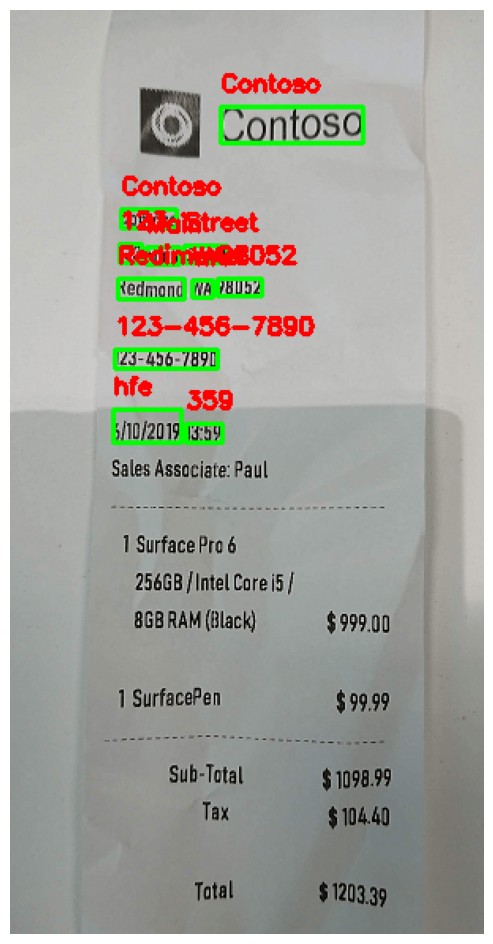

Document classification accuracy (Placeholder - More data needed): 1.0
Extracted text: ['Northwind Traders 123 Main Street 555-123-4567 2/17/2020 13:07 1 Apple $0.90 Sub-Total $1.70 Tax $0.17 Total $1.87']
Named entities: {'123': 'CARDINAL', '1': 'CARDINAL', 'Apple': 'ORG', '1.70': 'MONEY', '1.87': 'MONEY'}


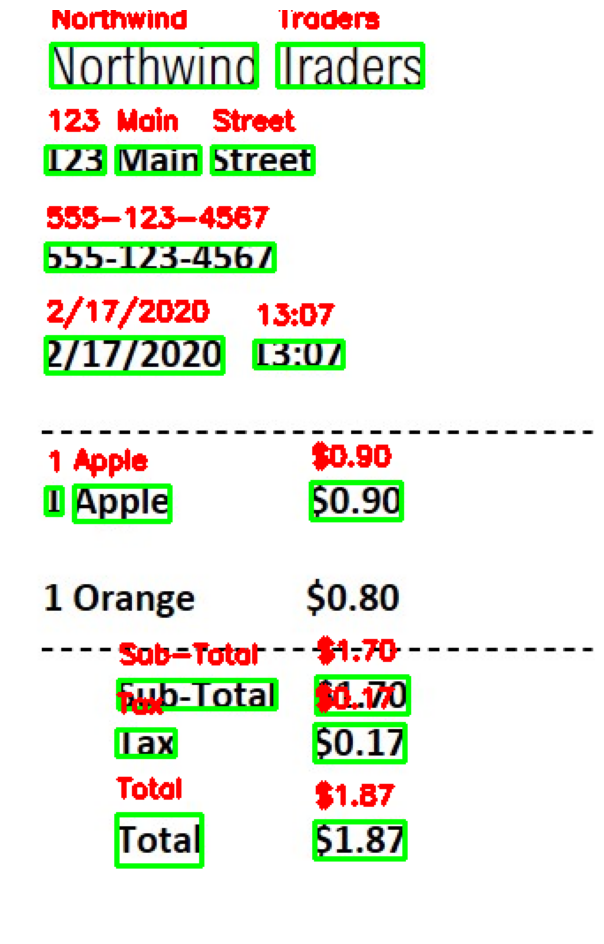

Document classification accuracy (Placeholder - More data needed): 1.0


In [18]:
# Test the image intelligence function
image_intelligence("./contoso-receipt-small.png")
image_intelligence("./receipt.jpg")

### 6.2. PDF document

Extracted text: ['Northwind Traders 123 Main Street 555-123-4567 2/17/2020 13:07 Sub-Total $1.70 Tax $0.17 Total $1.87']
Named entities: {'123': 'CARDINAL', '1.70': 'MONEY', '1.87': 'MONEY'}


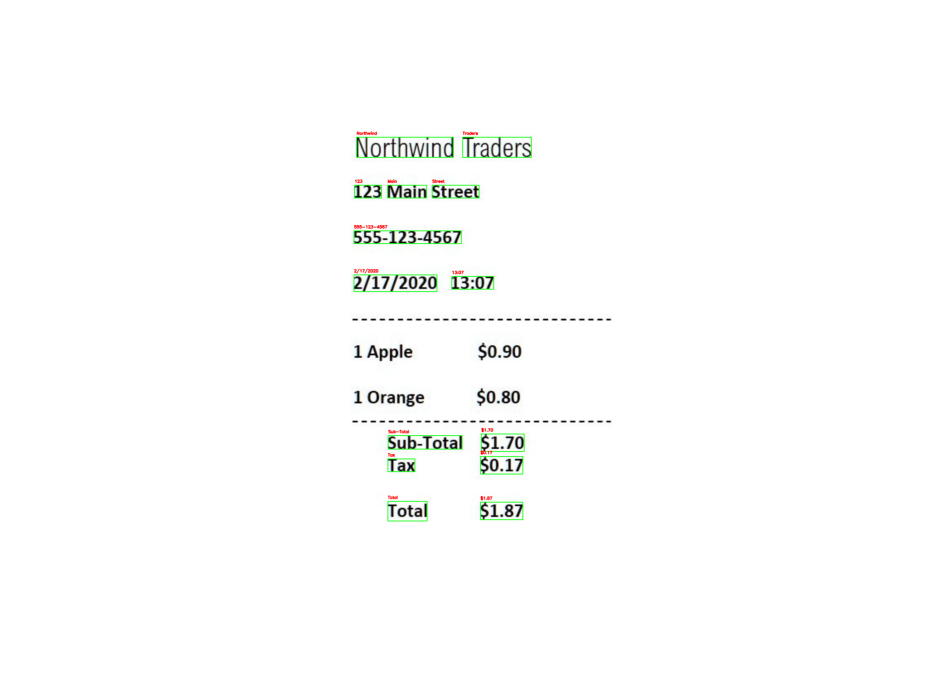

Document classification accuracy (Placeholder - More data needed): 1.0


In [19]:
# Test the image intelligence function with a PDF document
image_intelligence("./receipt.pdf")